## Neural Network Model with Top 20 Feature Importances (including census data)

In [5]:
#import libraries 
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
#read in data
# read in data
parcel_data=pd.read_csv('all_data_joined_2010.csv')



C:\Users\cpugh\AppData\Local\Temp\ipykernel_15064\2412231036.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  parcel_data=pd.read_csv('all_data_joined_2010.csv')


In [7]:
# need to set APN to be index so that we can join this back to other information later on
parceldata_10 = parcel_data
parceldata_10.set_index('APN',inplace=True)
parceldata_10.columns

Index(['GEO_ID', 'LAND_VALUE', 'distances', 'building_class', 'year', 'acres',
       'sqft', 'num_warehouses', 'warehouse_start', 'buit_within_decade',
       ...
       'tract_y_y', 'Percent Employee of private company workers',
       'Percent Self-employed in own incorporated business workers',
       'Percent Private not-for-profit wage and salary workers',
       'Percent Local government workers', 'Percent State government workers',
       'Percent Federal government workers',
       'Percent Self-employed in own not incorporated business workers',
       'Percent Unpaid family workers', 'geometry_census'],
      dtype='object', length=109)

In [8]:
parceldata_10 = parceldata_10.rename(columns = {'buit_within_decade': 'built_within_decade'})

In [9]:
# Create a dataset for data as of 2020
parceldata_20=pd.read_csv('data/all_data_joined_2020.csv')

# need to set APN to be index so that we can join this back to other information later on
parceldata_20.set_index('APN',inplace=True)

C:\Users\cpugh\AppData\Local\Temp\ipykernel_15064\2026702094.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  parceldata_20=pd.read_csv('data/all_data_joined_2020.csv')


In [10]:
parceldata_20 = parceldata_20.rename(columns = {'buit_within_decade': 'built_within_decade'})

## Standardize Data

Use top 20 feature importances from random forest to run a model with fewer columns that includes census data

In [11]:
#subset parceldata10 to run model with only top 20 feature importances
parceldata_10 = parceldata_10[['LAND_VALUE', 'ACRES', 'dollars_per_acre', 'distances', 'lon', 'lat',
       'IL_RATIO', 'warehouse_start', 'Industrial', 'Vacant',
       'Percent $10,000-$14,999', 'Percent $100,000 - $124,999',
       'Percent White alone', 'Percent Some other race alone',
       'Percent some_college', 'Percent less_highschool',
       'Percent Renter Occupied', 'Percent No schooling completed',
       'Percent Two or more races:', 'Percent Owner Occupied', 'built_within_decade']]

In [12]:
#standardize data

cols_to_exclude = ['built_within_decade']

otherCols  = [col for col in parceldata_10.columns if col not in cols_to_exclude]
otherCols

['LAND_VALUE',
 'ACRES',
 'dollars_per_acre',
 'distances',
 'lon',
 'lat',
 'IL_RATIO',
 'warehouse_start',
 'Industrial',
 'Vacant',
 'Percent $10,000-$14,999',
 'Percent $100,000 - $124,999',
 'Percent White alone',
 'Percent Some other race alone',
 'Percent some_college',
 'Percent less_highschool',
 'Percent Renter Occupied',
 'Percent No schooling completed',
 'Percent Two or more races:',
 'Percent Owner Occupied']

In [13]:
parceldata_10[otherCols].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1361745 entries, 507410018.0 to 41738112.0
Data columns (total 20 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   LAND_VALUE                      1361745 non-null  float64
 1   ACRES                           1361745 non-null  float64
 2   dollars_per_acre                1361745 non-null  float64
 3   distances                       1361745 non-null  float64
 4   lon                             1361745 non-null  float64
 5   lat                             1361745 non-null  float64
 6   IL_RATIO                        1361745 non-null  float64
 7   warehouse_start                 1361745 non-null  int64  
 8   Industrial                      1361745 non-null  float64
 9   Vacant                          1361745 non-null  float64
 10  Percent $10,000-$14,999         1361624 non-null  float64
 11  Percent $100,000 - $124,999     1361624 non-null

In [14]:
#scale "otherCols"
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(parceldata_10[otherCols])

# convert to DataFrame and specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(parceldata_10[otherCols]), 
                         columns=otherCols, index=parceldata_10.index)

# create a DataFrame with these scaled columns joined to the columns that we didn't scale
df_scaled = df_scaled.join(parceldata_10[cols_to_exclude])

df_scaled.head()

,LAND_VALUE,ACRES,dollars_per_acre,distances,lon,lat,IL_RATIO,warehouse_start,Industrial,Vacant,...,"Percent $100,000 - $124,999",Percent White alone,Percent Some other race alone,Percent some_college,Percent less_highschool,Percent Renter Occupied,Percent No schooling completed,Percent Two or more races:,Percent Owner Occupied,built_within_decade
APN,,,,,,,,,,,,,,,,,,,,,
507410018.0,-0.176485,-0.082442,-0.580737,-0.101686,2.401097,-0.675185,0.037989,-0.045107,-0.097917,-0.416609,...,-0.241563,1.252305,-1.110079,-0.377373,-0.899686,0.468743,-0.076801,-0.508191,-0.468743,0
507450006.0,-0.176485,-0.084718,-0.580737,-0.132124,2.415560,-0.675099,-0.085111,-0.045107,-0.097917,-0.416609,...,-0.241563,1.252305,-1.110079,-0.377373,-0.899686,0.468743,-0.076801,-0.508191,-0.468743,0
507450007.0,-0.176485,-0.082902,-0.580737,-0.135208,2.417040,-0.675092,-0.027709,-0.045107,-0.097917,-0.416609,...,-0.241563,1.252305,-1.110079,-0.377373,-0.899686,0.468743,-0.076801,-0.508191,-0.468743,0
507450018.0,-0.176485,-0.083995,-0.580737,-0.139460,2.419102,-0.675086,-0.004112,-0.045107,-0.097917,-0.416609,...,-0.241563,1.252305,-1.110079,-0.377373,-0.899686,0.468743,-0.076801,-0.508191,-0.468743,0
507450019.0,-0.176485,-0.083113,-0.580737,-0.142608,2.420626,-0.675077,0.029123,-0.045107,-0.097917,-0.416609,...,-0.241563,1.252305,-1.110079,-0.377373,-0.899686,0.468743,-0.076801,-0.508191,-0.468743,0


In [15]:


# define variables 
cols=df_scaled.columns.to_list()
xvars=[col for col in cols if col not in ('APN', 'built_within_decade')]
yvar = 'built_within_decade'

# create a dataframe with no NaNs
parceldata_10_model = df_scaled[xvars+[yvar]].dropna()

# create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    parceldata_10_model[xvars], parceldata_10_model[yvar], test_size = 0.25, random_state = 1)

In [16]:
parceldata_10_model[xvars].describe() ##check that it is standardized

,LAND_VALUE,ACRES,dollars_per_acre,distances,lon,lat,IL_RATIO,warehouse_start,Industrial,Vacant,"Percent $10,000-$14,999","Percent $100,000 - $124,999",Percent White alone,Percent Some other race alone,Percent some_college,Percent less_highschool,Percent Renter Occupied,Percent No schooling completed,Percent Two or more races:,Percent Owner Occupied
count,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06,1.361624e+06
mean,-1.501287e-04,-1.042402e-04,4.534924e-05,7.266677e-06,1.709083e-05,-9.825438e-05,8.980464e-07,-1.428257e-04,-6.702204e-05,1.012720e-05,-8.856997e-16,1.058698e-15,1.392034e-05,4.052026e-05,1.111224e-05,-1.137961e-04,-1.748355e-16,5.289485e-06,1.552845e-05,1.974372e-15
std,9.967208e-01,9.996661e-01,1.000032e+00,1.000041e+00,1.000041e+00,9.999597e-01,1.000029e+00,9.984191e-01,9.996613e-01,1.000010e+00,1.000000e+00,1.000000e+00,1.000021e+00,1.000008e+00,1.000021e+00,9.998934e-01,1.000000e+00,1.000020e+00,1.000011e+00,1.000000e+00
min,-1.764855e-01,-9.672326e-02,-5.807367e-01,-7.525699e-01,-1.801416e+00,-2.065440e+00,-2.486732e-01,-4.510670e-02,-9.791675e-02,-4.166089e-01,-1.253199e+00,-1.914640e+00,-3.311632e+00,-1.500227e+00,-4.145450e+00,-1.658578e+00,-1.720606e+00,-1.043605e+00,-1.787727e+00,-4.494060e+00
25%,-1.287210e-01,-9.167439e-02,-4.779186e-01,-5.870526e-01,-6.913193e-01,-6.560897e-01,-1.434577e-01,-4.510670e-02,-9.791675e-02,-4.166089e-01,-8.035978e-01,-8.137168e-01,-7.021586e-01,-7.771521e-01,-5.418739e-01,-7.565426e-01,-7.178288e-01,-7.237873e-01,-7.206871e-01,-4.738217e-01
50%,-7.667903e-02,-9.043419e-02,-2.077392e-01,-3.766366e-01,-1.130253e-01,-6.613351e-02,-2.375108e-02,-4.510670e-02,-9.791675e-02,-4.166089e-01,-2.098758e-01,-1.534055e-01,3.895192e-02,-2.207316e-01,7.310019e-02,-2.313552e-01,-2.676930e-01,-2.480261e-01,-5.324575e-02,2.676930e-01
75%,-8.108211e-03,-8.206196e-02,1.326415e-01,4.725624e-02,4.339844e-01,4.014753e-01,8.705805e-02,-4.510670e-02,-9.791675e-02,-4.166089e-01,4.157269e-01,7.895560e-01,7.520324e-01,5.265995e-01,7.211348e-01,5.274305e-01,4.738217e-01,3.936611e-01,6.448146e-01,7.178288e-01
max,3.705046e+02,1.053206e+02,2.531030e+02,5.213832e+00,2.893513e+00,3.602702e+00,7.724220e+02,2.216966e+01,1.021276e+01,2.400333e+00,7.022307e+00,6.342372e+00,1.989577e+00,5.119784e+00,2.865425e+00,3.544045e+00,4.494060e+00,9.380813e+00,4.596799e+00,1.720606e+00


In [17]:
#predict
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state = 1) ##add random state here or next line & check that it is using the standardized data
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [18]:
# stop if the length of the predictions doesn't match the training dataset
assert len(X_test)==len(y_pred)

In [19]:
#check how it did
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    340303
           1       0.60      0.33      0.42       103

    accuracy                           1.00    340406
   macro avg       0.80      0.67      0.71    340406
weighted avg       1.00      1.00      1.00    340406



In [20]:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 0.0002. Actual fraction True: 0.0003


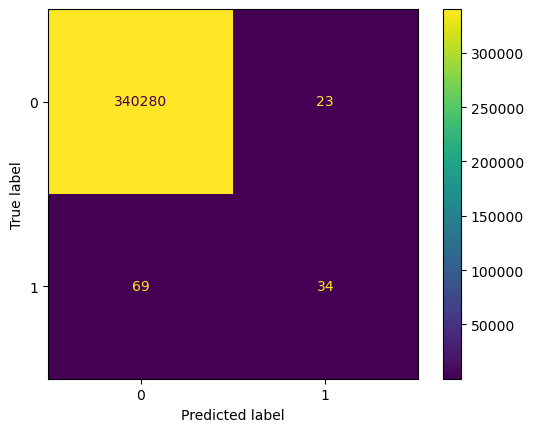

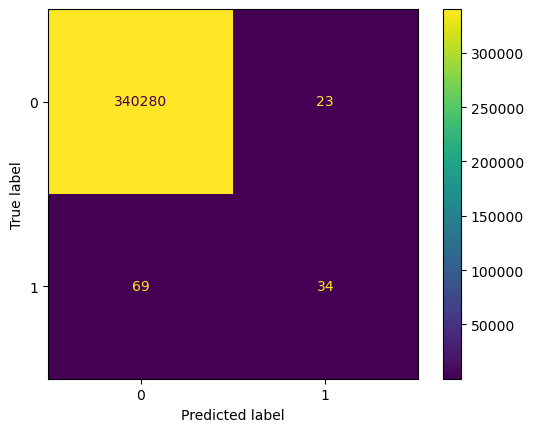

In [21]:
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.savefig('figures/confusion_matrix_Neuralnet_census.png', bbox_inches='tight',transparent=True)


### Apply Model to 2020 Dataset

### Standardize New Dataframe

In [22]:
#subset parceldata20 to run model with only top 20 feature importances
parceldata_20 = parceldata_20[['LAND_VALUE', 'ACRES', 'dollars_per_acre', 'distances', 'lon', 'lat',
       'IL_RATIO', 'warehouse_start', 'Industrial', 'Vacant',
       'Percent $10,000-$14,999', 'Percent $100,000 - $124,999',
       'Percent White alone', 'Percent Some other race alone',
       'Percent some_college', 'Percent less_highschool',
       'Percent Renter Occupied', 'Percent No schooling completed',
       'Percent Two or more races:', 'Percent Owner Occupied', 'built_within_decade']]

In [23]:
#select columns to standardize

cols_to_exclude = ['built_within_decade']

otherCols  = [col for col in parceldata_20.columns if col not in cols_to_exclude]
otherCols

['LAND_VALUE',
 'ACRES',
 'dollars_per_acre',
 'distances',
 'lon',
 'lat',
 'IL_RATIO',
 'warehouse_start',
 'Industrial',
 'Vacant',
 'Percent $10,000-$14,999',
 'Percent $100,000 - $124,999',
 'Percent White alone',
 'Percent Some other race alone',
 'Percent some_college',
 'Percent less_highschool',
 'Percent Renter Occupied',
 'Percent No schooling completed',
 'Percent Two or more races:',
 'Percent Owner Occupied']

In [24]:
#scale "otherCols"
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(parceldata_20[otherCols])

# convert to DataFrame and specify the column names and index
df_scaled2 = pd.DataFrame(scaler.transform(parceldata_20[otherCols]), 
                         columns=otherCols, index=parceldata_20.index)

# create a DataFrame with these scaled columns joined to the columns that we didn't scale
df_scaled2 = df_scaled2.join(parceldata_20[cols_to_exclude])

df_scaled2.head()

,LAND_VALUE,ACRES,dollars_per_acre,distances,lon,lat,IL_RATIO,warehouse_start,Industrial,Vacant,...,"Percent $100,000 - $124,999",Percent White alone,Percent Some other race alone,Percent some_college,Percent less_highschool,Percent Renter Occupied,Percent No schooling completed,Percent Two or more races:,Percent Owner Occupied,built_within_decade
APN,,,,,,,,,,,,,,,,,,,,,
210080008.0,0.558840,0.060890,-0.101812,-1.129714,1.729937,1.244025,-0.546842,-0.054508,-0.104203,-0.213287,...,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342,0.0
210060035.0,-0.264445,-0.085102,-0.841453,-1.091906,1.744182,1.264990,-0.793475,-0.054508,-0.104203,-0.213287,...,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342,0.0
210210051.0,0.041658,-0.124220,4.198635,-1.199217,1.688511,1.183121,-0.111019,-0.054508,-0.104203,-0.213287,...,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342,0.0
210210076.0,-0.264445,-0.042453,-0.841453,-1.215713,1.692483,1.183337,-0.793475,-0.054508,-0.104203,-0.213287,...,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342,0.0
210210046.0,-0.118679,-0.124622,1.652552,-1.223065,1.683192,1.184109,0.371419,-0.054508,-0.104203,-0.213287,...,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342,0.0


In [25]:
# define variables 
cols=df_scaled2.columns.to_list()
xvars=[col for col in cols if col not in ('APN', 'built_within_decade')]
yvar = 'built_within_decade'

# create a dataframe with no NaNs
parceldata_20_model = df_scaled2[xvars+[yvar]].dropna()

In [26]:
# apply predictions from previous model to test dataset
X_test=parceldata_20_model[xvars]
y_pred = mlp.predict(X_test)

In [27]:
# stop if lengths don't match
assert len(X_test)==len(y_pred)
# how many does it predict?
print('Predicted fraction True: {:.4f}'.format(y_pred.mean()))
print('Predicted number True: {:.0f}'.format(y_pred.sum()))

Predicted fraction True: 0.0001
Predicted number True: 7


In [28]:
# create a dataframe of predictions about whether or not a parcel will have a warehouse built on it within 10 years & join this to the full df
predictions = pd.DataFrame(mlp.predict_proba(X_test),columns = ['pred_noWH', 'pred_WH'])
predictions= predictions.join((X_test).reset_index())
predictions.set_index('APN',inplace=True)
predictions.head()

,pred_noWH,pred_WH,LAND_VALUE,ACRES,dollars_per_acre,distances,lon,lat,IL_RATIO,warehouse_start,...,"Percent $10,000-$14,999","Percent $100,000 - $124,999",Percent White alone,Percent Some other race alone,Percent some_college,Percent less_highschool,Percent Renter Occupied,Percent No schooling completed,Percent Two or more races:,Percent Owner Occupied
APN,,,,,,,,,,,,,,,,,,,,,
210080008.0,1.0,2.576388e-08,0.558840,0.060890,-0.101812,-1.129714,1.729937,1.244025,-0.546842,-0.054508,...,-1.009732,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342
210060035.0,1.0,2.246994e-08,-0.264445,-0.085102,-0.841453,-1.091906,1.744182,1.264990,-0.793475,-0.054508,...,-1.009732,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342
210210051.0,1.0,5.247900e-20,0.041658,-0.124220,4.198635,-1.199217,1.688511,1.183121,-0.111019,-0.054508,...,-1.009732,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342
210210076.0,1.0,1.962885e-08,-0.264445,-0.042453,-0.841453,-1.215713,1.692483,1.183337,-0.793475,-0.054508,...,-1.009732,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342
210210046.0,1.0,1.395008e-13,-0.118679,-0.124622,1.652552,-1.223065,1.683192,1.184109,0.371419,-0.054508,...,-1.009732,-1.384031,-2.290251,1.641363,2.233557,0.563535,0.775342,1.615659,-1.669286,-0.775342


In [ ]:
#predictions.to_csv('predictions_neuralnet1.csv')